In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy
import random

In [3]:
data_train = pd.read_csv('data_train.csv')

In [ ]:
data_train_10_minutes = data_train[data_train['Label'] < 10].copy()

In [4]:
data_clean = pd.read_csv('data_train_clean_onset.csv')

In [5]:
data_clean_train_10_minutes = data_clean[data_clean ['Label'] <= 10].copy()

In [3]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Create a PyTorch dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SleepDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.from_numpy(self.sequences[idx]).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Create a function to impute the missing values in the dataset
def impute_missing_values (dataframe, method = 'LOCF', limit = 20):

    # create a missing mask (column) fthat would indicate whether the values in any of the columns of mydata are missing
    # 1 indicates missing, 0 indicates not missing
    missing_mask = dataframe.isnull().sum(axis=1).astype(bool).astype(int)
    dataframe_imputed = dataframe.copy()
    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask.rename('ifmissing')], axis=1)

    if method == 'LOCF': 

        dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

        # fill the rest with backward fill 
        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

    elif method =='NOCB':

        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

        # fill the rest with forward fill
        #dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

    elif method == 'linear interpolation':
            
        dataframe_imputed.interpolate(method='linear', inplace=True, limit = limit)

    elif method == 'quadratic interpolation':

        dataframe_imputed.interpolate(method='quadratic', inplace=True, limit = limit)

    elif method == 'mean':

        dataframe_imputed.fillna(dataframe.mean(), inplace=True, limit = limit)

    elif method == 'median':

        dataframe_imputed.fillna(dataframe.median(), inplace=True, limit = limit)

    elif method == 'MICE':

        # Define an imputer
        imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                            missing_values=np.nan, 
                            sample_posterior=False,
                            max_iter=10, 
                            random_state=0, 
                            verbose=2)
                            

        columns = dataframe_imputed.columns

        # Apply the imputer
        df_imputed = imp.fit_transform(dataframe_imputed)

        # Convert back to DataFrame
        dataframe_imputed = pd.DataFrame(df_imputed, columns=columns)
    
    elif method == 'None':
        dataframe_imputed = dataframe_imputed

    missing_mask_new = dataframe_imputed.isnull().sum(axis=1).astype(bool).astype(int)

    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask_new.rename('ifmissing_after_imputation')], axis=1)

    return dataframe_imputed


In [5]:


# Create a function for creating sliding windows of selected length 

def create_sliding_windows(data,  window_size_minutes=5, 
                           ifmissing = True, random_seed = 42, ifoutputsubjects = 0, 
                           train_proportion = 0.6, ifoutput_end_points = 0,
                           resampling_method = None, resampling_proportion = 0.5, iftest = 1):

    # Assert whether therea are any NaNs in the data
    if not ifmissing:
        assert data.isnull().sum().sum() == 0, "There are NaNs in the data"

    
    # Create a list of all unique subjects
    subjects = data['Sbj_ID'].unique()

    # Randomly select some of the 80% of subjects to be in the training set, 20% to the validation set and 20% in the test set
    np.random.seed(random_seed)


    train_subjects = np.random.choice(subjects, size=int(train_proportion*len(subjects)), replace=False)
    

    if iftest == 1:
        val_proportions = (1 - train_proportion)/2
        val_subjects = np.random.choice(np.setdiff1d(subjects, train_subjects), size=int(val_proportions*len(subjects)), replace=False)
        test_subjects = np.setdiff1d(subjects, np.concatenate((train_subjects, val_subjects)))
    else: 
        val_proportions = 1 - train_proportion
        val_subjects = np.setdiff1d(subjects, train_subjects)
        test_subjects = []

    
    
    # Print the number of subjects in each set
    print(f'There are {len(train_subjects)} subjects in the training set, {len(val_subjects)} subjects in the validation set and {len(test_subjects)} subjects in the test set')
    
    
    # Create a new column in the dataframe that indicates whether the subject is in the training set, val set or the test set
    data['Set'] = 'train'
    data.loc[data['Sbj_ID'].isin(val_subjects), 'Set'] = 'val'
    data.loc[data['Sbj_ID'].isin(test_subjects), 'Set'] = 'test'

    # Sort your dataframe by Sbj_ID if not already sorted
    data = data.sort_values('Sbj_ID')

    # Convert the window size from minutes to 6-second epochs
    window_size = int((window_size_minutes*60)/6)

    # Create empty lists to store your sequences and labels
    train_sequences = []
    train_labels = []
    val_sequences = []
    val_labels = []
    test_sequences = []
    test_labels = []

    # Group the DataFrame by subject ID and iterate over each group, dividing into training and test sets
    if ifoutput_end_points == 1:
        test_end_points = []
        test_sleep_stages = []
        test_labels = []
        val_sleep_stages = []
        val_end_points = []
    for _, group in data.groupby('Sbj_ID'):
        group = group.sort_values('Label', ascending=False)
        
        # For each group, get the feature columns and convert them into numpy array
        if ifoutput_end_points == 1:
             group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'Old_label', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()
             group_old_labels = group['Old_label'].to_numpy()
             group_sleep_stages = group['SleepStage'].to_numpy()
             group_labels = group['Label'].to_numpy()
        else:
            group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()

        ifmissing_column = group['ifmissing_after_imputation'].to_numpy()

        train_test = group['Set'].iloc[0]
        
        if window_size == len(group_features):
            if train_test == 'train':
                print('got here')
                train_sequences.append(group_features)
                train_labels.append(group['Label'].iloc[0])
            elif train_test == 'val':
                val_sequences.append(group_features)
                val_labels.append(group['Label'].iloc[0])
            elif train_test == 'test':
                test_sequences.append(group_features)
                test_labels.append(group['Label'].iloc[0])
        elif window_size > len(group_features):
            continue

       
        # Iterate over the group array with a sliding window
        for i in range(len(group_features) - window_size):
            
            # If there are any NaNs in the window, skip it
            if ifmissing_column[i : i + window_size].sum() > 0:
                continue

            if train_test == 'train':

                # Append the window data to your sequences
                train_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                train_labels.append(group['Label'].iloc[i])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    test_end_points.append(group_old_labels[i+window_size])
                    test_sleep_stages.append(group_sleep_stages[i+window_size])
            
            elif train_test == 'val':
                # Append the window data to your sequences
                val_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                val_labels.append(group['Label'].iloc[i])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    val_end_points.append(group_old_labels[i+window_size])
                    val_sleep_stages.append(group_sleep_stages[i+window_size])
            

            elif train_test == 'test':
                
                # Append the window data to your sequences
                test_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                test_labels.append(group['Label'].iloc[i])
                        
            
    # Convert the sequences and labels into numpy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)
    val_sequences = np.array(val_sequences)
    val_labels = np.array(val_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    
    if iftest == 1:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects, test_end_points, test_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels,  test_sequences, test_labels
    else:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels,  train_subjects, val_subjects, val_end_points, val_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, train_subjects, val_subjects
            
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels


In [6]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

# Train function
def train_regression(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, ifplot = False, batch_size = 1):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        print ('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Train the model
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            predictions, actuals = [], []
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)  # these are outputs now
                val_loss += criterion(outputs, labels.view(-1, 1)).item()

                predictions.extend(outputs.cpu().numpy().flatten())
                actuals.extend(labels.cpu().numpy())    

            # Calculate metrics
            mse = mean_squared_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)
            mae = mean_absolute_error(actuals, predictions)

            if ifplot:
                print('-'*100)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')
                print(f'Mean Squared Error: {mse}, R2 Score: {r2}')

        # Save the model training and validation losses for plotting 
        train_losses.append(loss.item())
        val_losses.append(val_loss/len(val_loader))

    return train_losses, val_losses, model, optimizer, mse, r2, mae

# Test function
def test_regression(model, test_loader, device, criterion):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # these are outputs now
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy())

        print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print('Mean Squared Error:', mse)
    print('R2 Score:', r2)
    print('Mean Absolute Error:', mae)

    return predictions, actuals, mse, r2, mae

In [10]:
import torch
import torch.nn as nn

class SleepOnsetRNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.0, l2=0.0):
        super(SleepOnsetRNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.l2 = l2

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [11]:
def evaluate_performance_test(predictions, y_test):

    # check if the predictions are in the correct format
    if type(predictions) == list:
        predictions = np.array(predictions)

    # check if the y_test is in the correct format
    if type(y_test) == list:
        y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)


    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Accuracy:', round(accuracy, 2), '%.')
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R2:', round(r2, 2))


    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    plt.show()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals')
    plt.show()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    plt.show()

    return predictions, errors, mape, accuracy, residuals

In [12]:
from sklearn.metrics import mean_squared_error

def training_loop_feature_RNN_regression(mydata, filling_limit, method, input_size, 
                                         num_epochs, hidden_size, num_layers, dropout, 
                                         l2, lr, weight_decay, batch_size, device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=0, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=False, ifsaveplots=True, output_path=None):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

    # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.8, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = 1)


    # Define the loss function for regression
    criterion = nn.MSELoss()

    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model (This model needs to be defined as a regression model)
    model = SleepOnsetRNNRegressor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, l2=l2).to(device)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)


        evaluate_performance_test(predictions, actuals)
        return train_losses, val_losses, model, predictions, actuals, mse

    else:
        if ifoutputpredictions:
            return train_losses, val_losses, model, predictions, actuals
        else:
            return train_losses, val_losses, model


## Try without shuffling the training batch: 

In [13]:
training_loop_feature_RNN_regression(data_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 4, hidden_size = 128, num_layers = 2, dropout = 0.1, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.001, batch_size = 32, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

NameError: name 'data_train_10_minutes' is not defined

In [ ]:
training_loop_feature_RNN_regression(data_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 4, hidden_size = 128, num_layers = 2, dropout = 0.1, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.001, batch_size = 32, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 1, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_clean_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 4, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_clean_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 3, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1.5, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_clean_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 3, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_clean_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 128, num_layers = 3, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
training_loop_feature_RNN_regression(data_clean_train_10_minutes, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 1, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
## Try a dataset where instead of minutes we use seconds 
data_seconds = data_train.copy()
data_seconds['Label'] = data_seconds['Label'] * 60

In [ ]:
data_seconds

In [ ]:
training_loop_feature_RNN_regression(data_seconds, filling_limit = 0, method = None, input_size = 86, 
                                         num_epochs = 10, hidden_size = 64, num_layers = 3, dropout = 0, 
                                         l2 = 0, lr = 0.0001, weight_decay = 0.1, batch_size = 16, device = device, 
                                         random_seed=42, window_size_minutes = 1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, 
                                         ifplot=False, ifsaveplots=True, output_path=None)

In [ ]:
from sklearn.metrics import mean_squared_error

def training_loop_RNN_regression_normalised(mydata, filling_limit, method, input_size, 
                                         num_epochs, hidden_size, num_layers, dropout, 
                                         l2, lr, weight_decay, batch_size, device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=0, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=False, ifsaveplots=True, output_path=None):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

    # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = random_seed, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.8, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = 1)
    # Normalize target values
    all_targets = np.concatenate([train_targets, val_targets, test_targets])
    min_target = np.min(all_targets)
    max_target = np.max(all_targets)

    train_targets = (train_targets - min_target) / (max_target - min_target)
    val_targets = (val_targets - min_target) / (max_target - min_target)
    test_targets = (test_targets - min_target) / (max_target - min_target)

    # Define the loss function for regression
    criterion = nn.MSELoss()

    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model (This model needs to be defined as a regression model)
    model = SleepOnsetRNNRegressor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, l2=l2).to(device)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, ifplot=ifplot, ifsaveplots=ifsaveplots, output_path=output_path)

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion)
        # check if the predictions are in the correct format
        # check if the predictions are in the correct format
        if type(predictions) == list:
            predictions = np.array(predictions)

        # check if the y_test is in the correct format
        if type(actuals) == list:
            actuals = np.array(actuals)


        # De-normalize predictions and actuals
        predictions = predictions * (max_target - min_target) + min_target
        actuals = actuals * (max_target - min_target) + min_target

        
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)


        evaluate_performance_test(predictions, actuals)
        return train_losses, val_losses, model, predictions, actuals, mse

    else:
        if ifoutputpredictions:
            # De-normalize predictions and actuals if outputting
            predictions = predictions * (max_target - min_target) + min_target
            actuals = actuals * (max_target - min_target) + min_target
            return train_losses, val_losses, model, predictions, actuals
        else:
            return train_losses, val_losses, model

## Try Stateful RNN

In [25]:
class StatefulRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StatefulRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

In [24]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

# Train function
def train_regression(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, ifplot = False, num_layers = 2, batch_size = 32, hidden_size = 64):

    def init_hidden():
        return (torch.zeros(num_layers, batch_size, hidden_size).to(device),
                torch.zeros(num_layers, batch_size, hidden_size).to(device))
    
    train_losses = []
    val_losses = []

    hidden = init_hidden()

    for epoch in range(num_epochs):

        print ('Epoch {}/{}'.format(epoch+1, num_epochs))

    
        for i, (sequences, labels) in enumerate(train_loader):
            # Move sequences and labels to the appropriate device
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs, hidden = model(sequences, hidden)
            
            # Detach the hidden states; this breaks the backpropagation graph so 
            # that we don't backpropagate through all time steps
            hidden = (hidden[0].detach(), hidden[1].detach())

            # Reset the hidden state after every 30 batches
            if ((i + 1)//batch_size) % 300 == 0:
                hidden = init_hidden()

            labels = labels.view(-1, 1)  # Reshape the labels to [10, 1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            predictions, actuals = [], []
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs, hidden = model(sequences, hidden)
            
                # Detach the hidden states; this breaks the backpropagation graph so 
                # that we don't backpropagate through all time steps
                hidden = (hidden[0].detach(), hidden[1].detach())

                # Reset the hidden state after every 30 batches
                if ((i + 1)//batch_size) % 300 == 0:
                    hidden = init_hidden()
                labels = labels.view(-1, 1)
                val_loss += criterion(outputs, labels.view(-1, 1)).item()

                predictions.extend(outputs.cpu().numpy().flatten())
                
                actuals.extend(labels.cpu().numpy().flatten())    

            # Calculate metrics
            mse = mean_squared_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)
            mae = mean_absolute_error(actuals, predictions)

            if ifplot:
                print('-'*100)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')
                print(f'Mean Squared Error: {mse}, R2 Score: {r2}')

        # Save the model training and validation losses for plotting 
        train_losses.append(loss.item())
        val_losses.append(val_loss/len(val_loader))

    return train_losses, val_losses, model, optimizer, mse, r2, mae

def test_regression(model, test_loader, device, criterion, num_layers=2, batch_size=32, hidden_size=64):

    def init_hidden():
        return (torch.zeros(num_layers, batch_size, hidden_size).to(device),
                torch.zeros(num_layers, batch_size, hidden_size).to(device))

    hidden = init_hidden()

    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        test_loss = 0
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, hidden = model(inputs, hidden)
            
            # Detach the hidden state to prevent unnecessary gradients computation (since we're in eval mode anyway)
            hidden = (hidden[0].detach(), hidden[1].detach())

            labels = labels.view(-1, 1)
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

            # If you want to reset hidden state after every 30 batches, you can add:
            if ((i + 1)//batch_size)% 300 == 0:
                print(i)
                hidden = init_hidden()

        print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print('Mean Squared Error:', mse)
    print('R2 Score:', r2)
    print('Mean Absolute Error:', mae)

    return predictions, actuals, mse, r2, mae


In [34]:
import torch
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELoss()
loss = criterion(predictions, targets)
print(loss)

tensor(0.1245)


In [26]:
def evaluate_performance_test(predictions, y_test):

    # check if the predictions are in the correct format
    if type(predictions) == list:
        predictions = np.array(predictions)

    # check if the y_test is in the correct format
    if type(y_test) == list:
        y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)


    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Accuracy:', round(accuracy, 2), '%.')
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R2:', round(r2, 2))
    


    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    plt.show()
    plt.close()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals')
    plt.show()
    plt.close()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    plt.show()
    plt.close()

    # for each actual, plot the mean residual 
    # round y_test to 0.1 decimal place
    y_test = np.round(y_test, 1)

    predictions_residuals_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in predictions_residuals_dict:
            predictions_residuals_dict[y_test[i]] = []
        predictions_residuals_dict[y_test[i]].append(residuals[i])
    
    # sort it in ascending order of keys
    predictions_residuals_dict = dict(sorted(predictions_residuals_dict.items()))


    actual_predictions_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in actual_predictions_dict:
            actual_predictions_dict[y_test[i]] = []
        actual_predictions_dict[y_test[i]].append(predictions[i])
    
    # sort it in ascending order of keys
    actual_predictions_dict = dict(sorted(actual_predictions_dict.items()))

    
    predictions_residuals_mean_dict = {}
    for key in predictions_residuals_dict:
        predictions_residuals_mean_dict[key] = np.mean(predictions_residuals_dict[key])
    
    # sort it in ascending order of keys
    predictions_residuals_mean_dict = dict(sorted(predictions_residuals_mean_dict.items()))


    residuals_std_dict = {}
    for key in predictions_residuals_dict:
        residuals_std_dict[key] = np.std(predictions_residuals_dict[key])
    # sort it in ascending order of keys
    residuals_std_dict = dict(sorted(residuals_std_dict.items()))

    
    actuals_predictions_mean_dict = {}
    for key in actual_predictions_dict:
        actuals_predictions_mean_dict[key] = np.mean(actual_predictions_dict[key])
    
    # sort it in ascending order of keys
    actuals_predictions_mean_dict = dict(sorted(actuals_predictions_mean_dict.items()))

    predictions_std_dict = {}
    for key in actual_predictions_dict:
        predictions_std_dict[key] = np.std(actual_predictions_dict[key])
    # sort it in ascending order of keys
    predictions_std_dict = dict(sorted(predictions_std_dict.items()))

    plt.plot(list(predictions_residuals_mean_dict.keys()), list(predictions_residuals_mean_dict.values()))
    # create std shading
    plt.fill_between(list(predictions_residuals_mean_dict.keys()),
                        np.array(list(predictions_residuals_mean_dict.values())) - np.array(list(residuals_std_dict.values())),
                        np.array(list(predictions_residuals_mean_dict.values())) + np.array(list(residuals_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = 0)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Residuals for this actual')
    plt.title('Actual vs Residuals')
    plt.show()

    plt.plot(list(actuals_predictions_mean_dict.keys()), list(actuals_predictions_mean_dict.values()))
    # create std shading
    plt.fill_between(list(actuals_predictions_mean_dict.keys()),
                        np.array(list(actuals_predictions_mean_dict.values())) - np.array(list(predictions_std_dict.values())),
                        np.array(list(actuals_predictions_mean_dict.values())) + np.array(list(predictions_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = y)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Prediction for this actual')
    plt.title('Actual vs Predictions')
    plt.show()

    return predictions, errors, mape, accuracy, residuals

In [33]:
from sklearn.metrics import mean_squared_error

def training_loop_RNN_stateful(mydata, filling_limit, method, input_size, 
                                         num_epochs, hidden_size, num_layers, dropout, 
                                         l2, lr, weight_decay, batch_size, device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=0, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=False, ifsaveplots=True, output_path=None, loss_function=None):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

    # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = random_seed, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.8, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = 1)
    # Normalize target values
   # all_targets = np.concatenate([train_targets, val_targets, test_targets])
    #min_target = np.min(all_targets)
   # max_target = np.max(all_targets)

   # train_targets = (train_targets - min_target) / (max_target - min_target)
   # val_targets = (val_targets - min_target) / (max_target - min_target)
   # test_targets = (test_targets - min_target) / (max_target - min_target)

    # Define the loss function for regression
     
    if loss_function is None:
        criterion = nn.MSELoss()
    else:
        criterion = loss_function

    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model (This model needs to be defined as a regression model)
    model = StatefulRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, 
                                                                               num_layers=num_layers, batch_size = batch_size, hidden_size=hidden_size, ifplot=ifplot)

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion, num_layers=num_layers, batch_size = batch_size, hidden_size=hidden_size)
        # check if the predictions are in the correct format
        # check if the predictions are in the correct format
        if type(predictions) == list:
            predictions = np.array(predictions)

        # check if the y_test is in the correct format
        if type(actuals) == list:
            actuals = np.array(actuals)


        # De-normalize predictions and actuals
        #predictions = predictions * (max_target - min_target) + min_target
       # actuals = actuals * (max_target - min_target) + min_target

        
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)

        
    

        evaluate_performance_test(predictions, actuals)
        return train_losses, val_losses, model, predictions, actuals, mse

    else:
        if ifoutputpredictions:
            # De-normalize predictions and actuals if outputting
            #p#redictions = predictions * (max_target - min_target) + min_target
            #actuals = actuals * (max_target - min_target) + min_target
            return train_losses, val_losses, model, predictions, actuals
        else:
            return train_losses, val_losses, model#

In [28]:
data_clean = pd.read_csv('data_train_clean_onset.csv')

In [29]:

# fill nan with previous value
data_clean_filled = data_clean.fillna(method='ffill').copy()
data_clean_filled = data_clean_filled.fillna(method='bfill').copy()
data_clean_filled.isnull().sum()

Label          0
Sbj_ID         0
Age            0
Gender         0
Race1          0
              ..
insmnia5       0
rstlesslgs5    0
whiirs5c       0
epslpscl5c     0
hoostmeq5c     0
Length: 90, dtype: int64

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/1
----------------------------------------------------------------------------------------------------
Epoch 1/1, Loss: 49.65980529785156, Validation Loss: 82.09695049202958
Mean Squared Error: 82.09695434570312, R2 Score: -0.07067716351281361


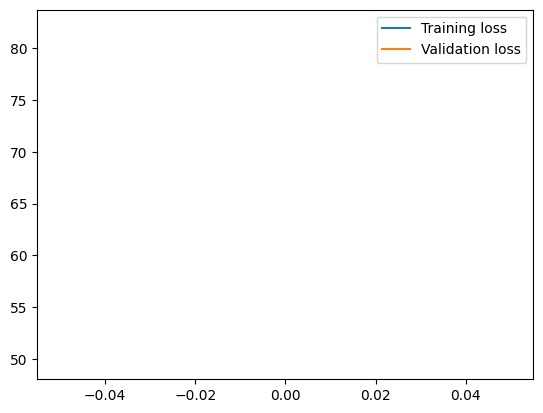

299
599
899
1199
1499
1799
2099
2399
2699
2999
3299
3599
3899
4199
4499
4799
5099
5399
5699
5999
6299
6599
6899
7199
7499
7799
8099
8399
8699
8999
Test Loss: 79.78490353561597
Mean Squared Error: 79.784904
R2 Score: -0.04006900025747617
Mean Absolute Error: 7.5465603
Test MSE: 79.784904
Test R2: -0.04006900025747617
Test MAE: 7.5465603
Mean Absolute Error: 7.55
Accuracy: -inf %.
Mean Squared Error: 79.78
Root Mean Squared Error: 8.93
R2: -0.04


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_5163/3247790938.py:14: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


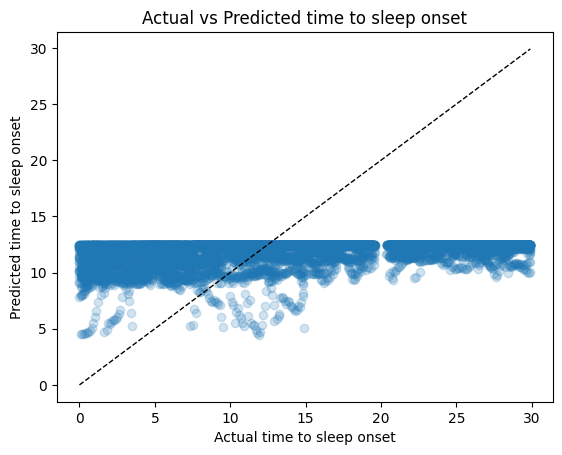

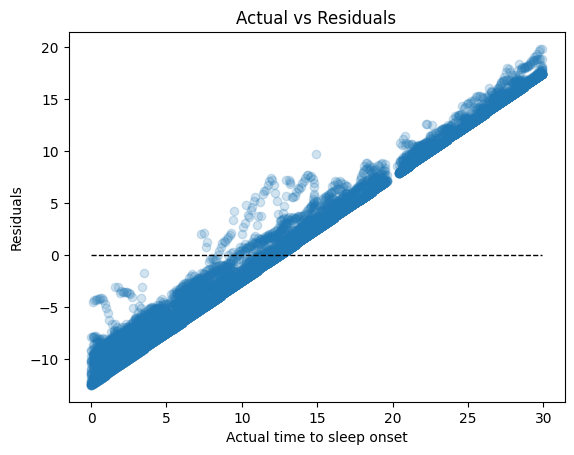

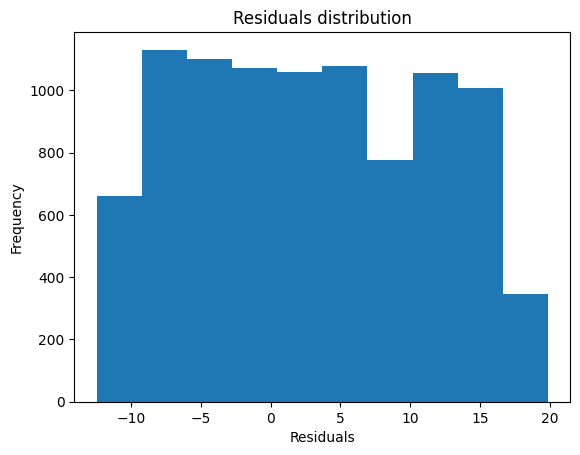

([49.65980529785156],
 [82.09695049202958],
 StatefulRNN(
   (lstm): LSTM(86, 32, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 array([ 9.259982,  9.70358 ,  9.711136, ..., 12.452762, 12.45283 ,
        12.452565], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 19.2, 19.3, 19.5], dtype=float32),
 79.784904)

In [89]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 1, hidden_size = 32, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.00001, weight_decay = 0.5, batch_size = 1, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 52.35475540161133, Validation Loss: 83.78413214991483
Mean Squared Error: 83.78414154052734, R2 Score: -0.09268074416920835
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 28.541223526000977, Validation Loss: 76.95631838916891
Mean Squared Error: 76.9563217163086, R2 Score: -0.00363499732311956
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 20.58805274963379, Validation Loss: 76.72245243595319
Mean Squared Error: 76.72245788574219, R2 Score: -0.000585006623945894
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 4/5, Loss: 18.95

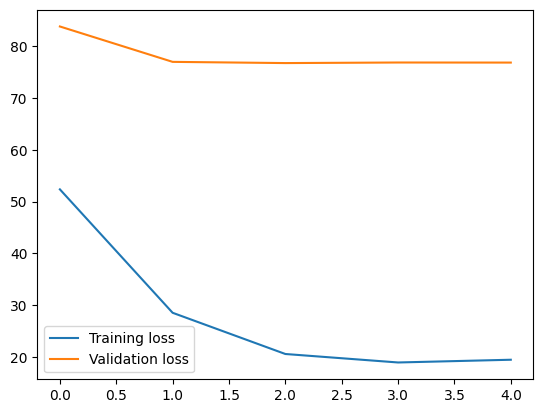

299
599
899
1199
1499
1799
2099
2399
2699
2999
3299
3599
3899
4199
4499
4799
5099
5399
5699
5999
6299
6599
6899
7199
7499
7799
8099
8399
8699
8999
Test Loss: 64.66930138554862
Mean Squared Error: 64.669304
R2 Score: 0.15697666276688693
Mean Absolute Error: 6.713632
Test MSE: 64.669304
Test R2: 0.15697666276688693
Test MAE: 6.713632
Mean Absolute Error: 6.71
Accuracy: -inf %.
Mean Squared Error: 64.67
Root Mean Squared Error: 8.04
R2: 0.16


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/3247790938.py:14: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


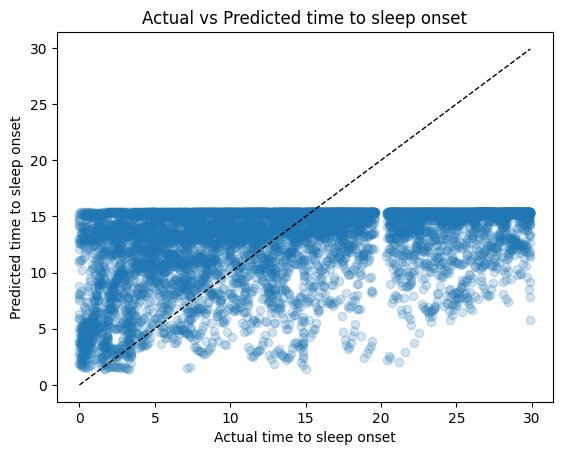

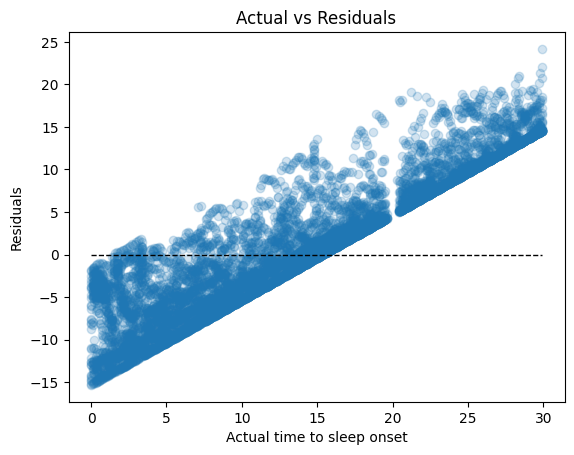

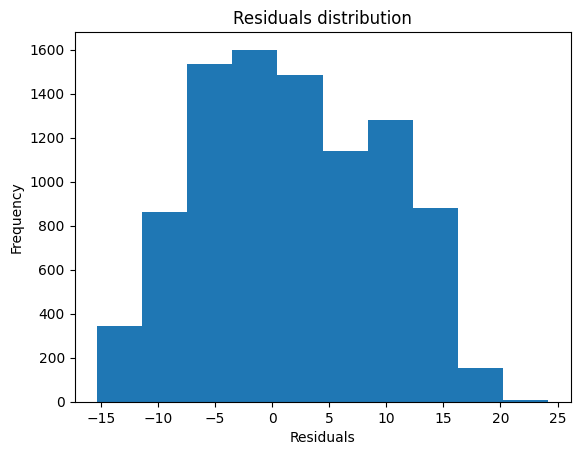

([52.35475540161133,
  28.541223526000977,
  20.58805274963379,
  18.95154571533203,
  19.480344772338867],
 [83.78413214991483,
  76.95631838916891,
  76.72245243595319,
  76.83237763373273,
  76.81832024258732],
 StatefulRNN(
   (lstm): LSTM(86, 32, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 array([ 9.921302, 12.496689, 13.057926, ..., 15.34784 , 15.349532,
        15.343584], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 19.2, 19.3, 19.5], dtype=float32),
 64.669304)

In [20]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 5, hidden_size = 32, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.00001, weight_decay = 0.5, batch_size = 1, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 7.583463668823242, Validation Loss: 80.56719399378338
Mean Squared Error: 80.56719207763672, R2 Score: -0.05072666183654806
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 5.334071159362793, Validation Loss: 82.50357130848498
Mean Squared Error: 82.50357055664062, R2 Score: -0.07598015734849883
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 10.519758224487305, Validation Loss: 78.88524295049532
Mean Squared Error: 78.88523864746094, R2 Score: -0.028791296863766025
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 4/5, Loss: 20.4

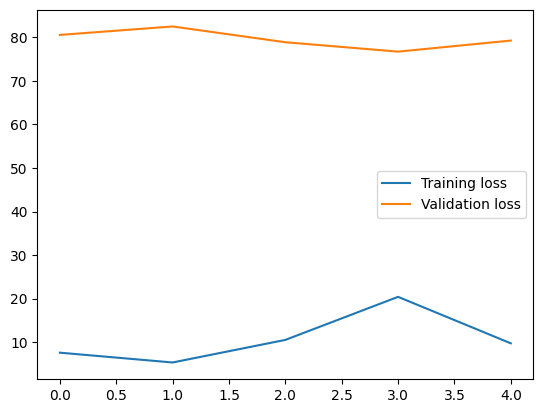

299
599
899
1199
1499
1799
2099
2399
2699
2999
3299
3599
3899
4199
4499
4799
5099
5399
5699
5999
6299
6599
6899
7199
7499
7799
8099
8399
8699
8999
Test Loss: 78.54558912586599
Mean Squared Error: 78.545586
R2 Score: -0.023913406379018287
Mean Absolute Error: 7.6749334
Test MSE: 78.545586
Test R2: -0.023913406379018287
Test MAE: 7.6749334
Mean Absolute Error: 7.67
Accuracy: -inf %.
Mean Squared Error: 78.55
Root Mean Squared Error: 8.86
R2: -0.02


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


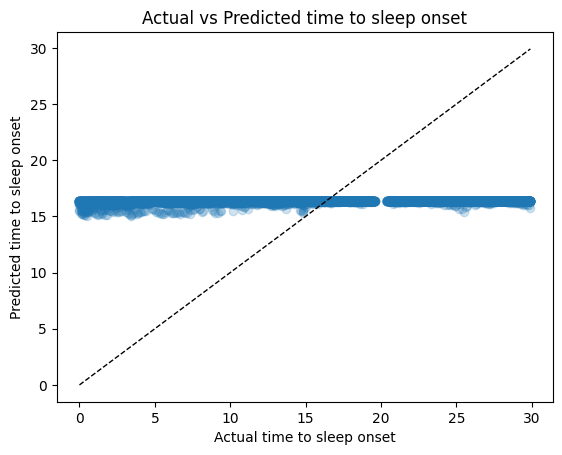

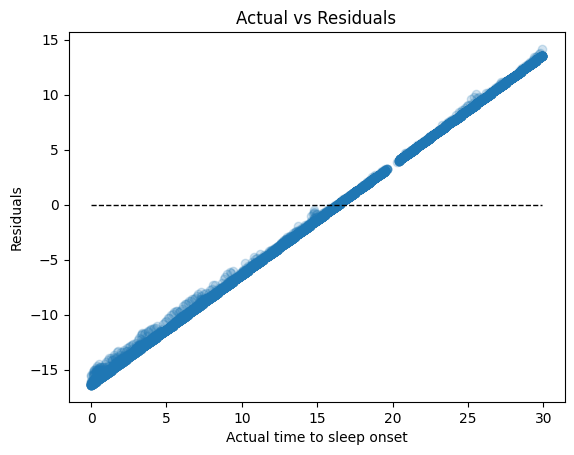

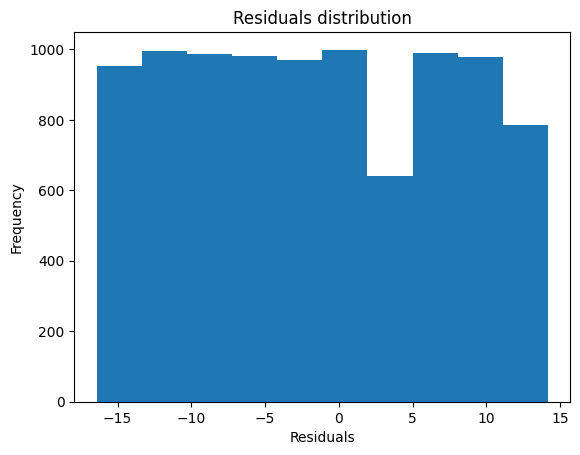

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


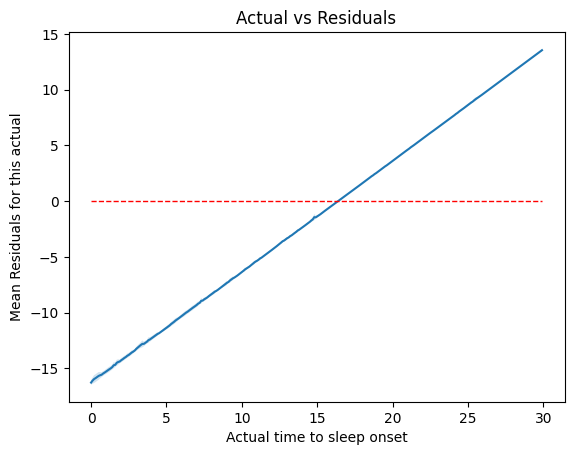

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


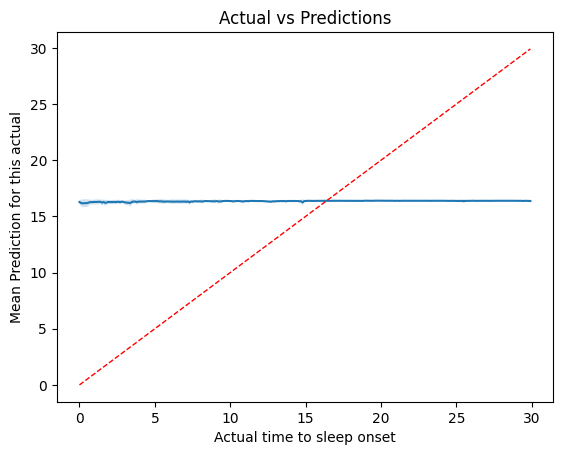

([7.583463668823242,
  5.334071159362793,
  10.519758224487305,
  20.405841827392578,
  9.73265552520752],
 [80.56719399378338,
  82.50357130848498,
  78.88524295049532,
  76.72404372195881,
  79.26674379883708],
 StatefulRNN(
   (lstm): LSTM(86, 32, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 array([16.379517, 16.384987, 16.3822  , ..., 16.395182, 16.397001,
        16.394215], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 19.2, 19.3, 19.5], dtype=float32),
 78.545586)

In [23]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 5, hidden_size = 32, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.5, batch_size = 1, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.1596824675798416, Validation Loss: 102.798043480411
Mean Squared Error: 102.79804229736328, R2 Score: -0.34065293471477864
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.39834702014923096, Validation Loss: 105.14267618231904
Mean Squared Error: 105.14266967773438, R2 Score: -0.37123074151165825
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.1845395714044571, Validation Loss: 103.0918568829811
Mean Squared Error: 103.09185028076172, R2 Score: -0.3444847372187747
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 4/5, Loss: 

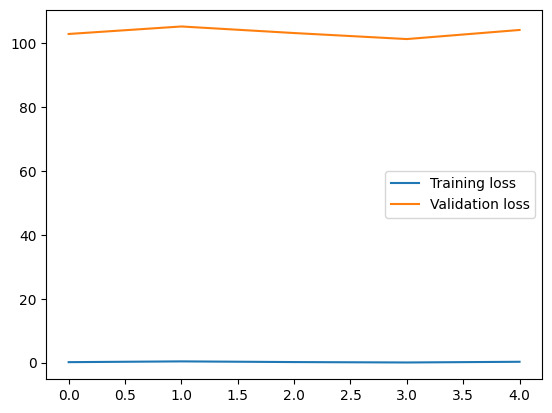

299
599
899
1199
1499
1799
2099
2399
2699
2999
3299
3599
3899
4199
4499
4799
5099
5399
5699
5999
6299
6599
6899
7199
7499
7799
8099
8399
8699
8999
Test Loss: 103.26293361614988
Mean Squared Error: 103.26293
R2 Score: -0.3461265398642681
Mean Absolute Error: 8.604521
Test MSE: 103.26293
Test R2: -0.3461265398642681
Test MAE: 8.604521
Mean Absolute Error: 8.6
Accuracy: -inf %.
Mean Squared Error: 103.26
Root Mean Squared Error: 10.16
R2: -0.35


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


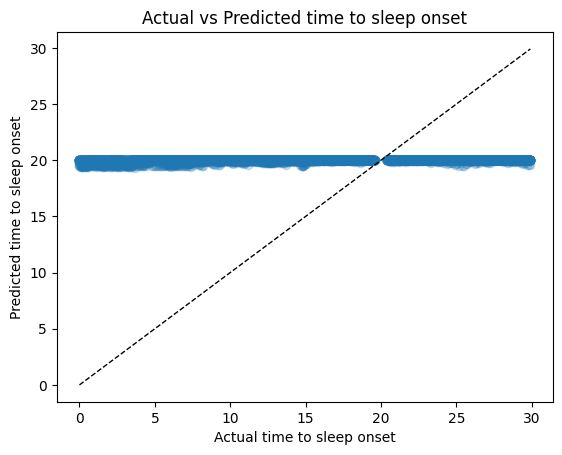

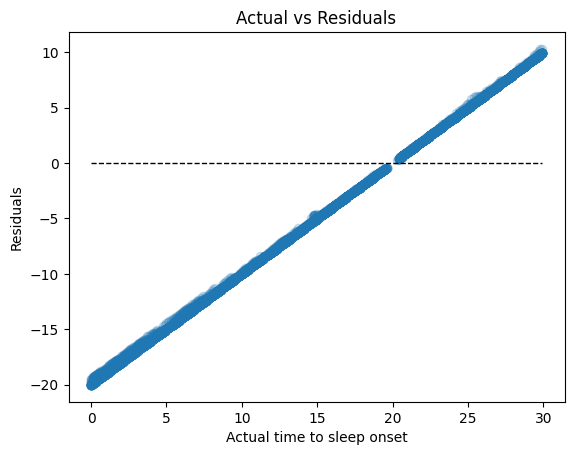

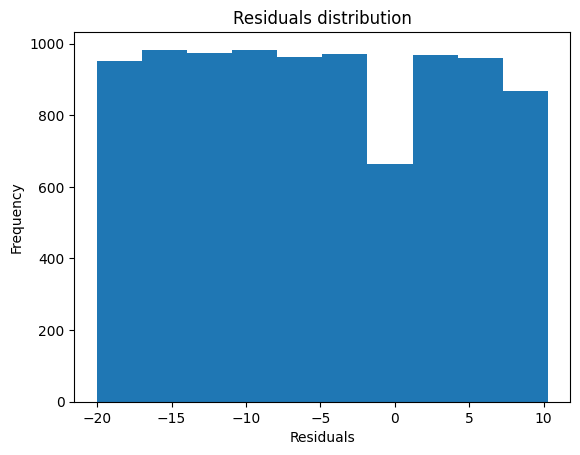

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


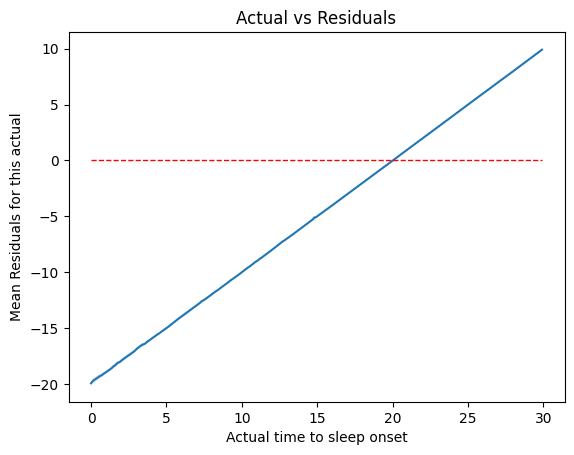

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


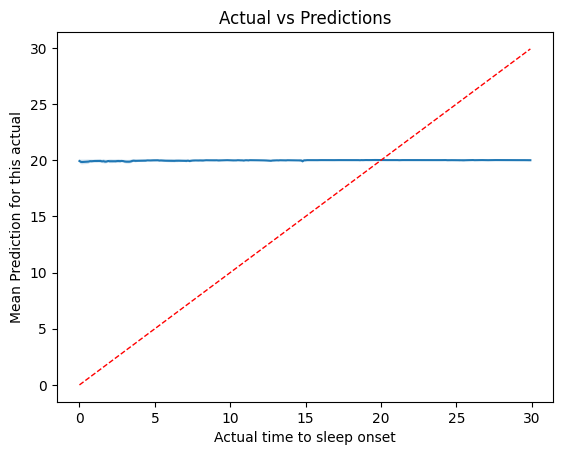

([0.1596824675798416,
  0.39834702014923096,
  0.1845395714044571,
  0.05700269341468811,
  0.27528825402259827],
 [102.798043480411,
  105.14267618231904,
  103.0918568829811,
  101.20584543006778,
  104.0522607497811],
 StatefulRNN(
   (lstm): LSTM(86, 128, num_layers=2, batch_first=True)
   (fc): Linear(in_features=128, out_features=1, bias=True)
 ),
 array([20.003244, 20.005888, 20.00245 , ..., 20.012243, 20.013186,
        20.009352], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 19.2, 19.3, 19.5], dtype=float32),
 103.26293)

In [32]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 5, hidden_size = 128, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.5, batch_size = 1, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 12.60952377319336, Validation Loss: 78.06267614997533
Mean Squared Error: 78.06267547607422, R2 Score: -0.018063693309615436
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 6.524226188659668, Validation Loss: 81.38922477180792
Mean Squared Error: 81.38922119140625, R2 Score: -0.06144727495590341
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 7.559499740600586, Validation Loss: 80.58561217347363
Mean Squared Error: 80.58560943603516, R2 Score: -0.05096686301729125
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 4/5, Loss: 8.768

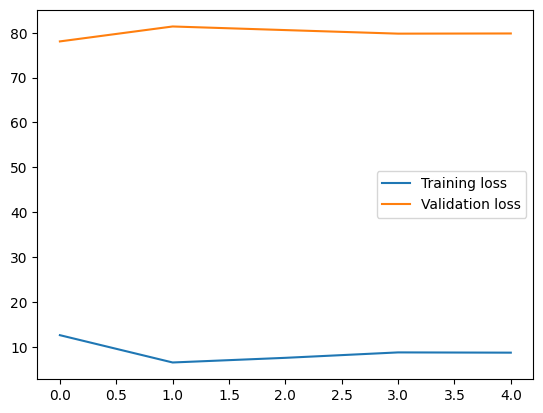

299
599
899
1199
1499
1799
2099
2399
2699
2999
3299
3599
3899
4199
4499
4799
5099
5399
5699
5999
6299
6599
6899
7199
7499
7799
8099
8399
8699
8999
Test Loss: 79.44474087461371
Mean Squared Error: 79.44474
R2 Score: -0.03563467012322419
Mean Absolute Error: 7.7134194
Test MSE: 79.44474
Test R2: -0.03563467012322419
Test MAE: 7.7134194
Mean Absolute Error: 7.71
Accuracy: -inf %.
Mean Squared Error: 79.44
Root Mean Squared Error: 8.91
R2: -0.04


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


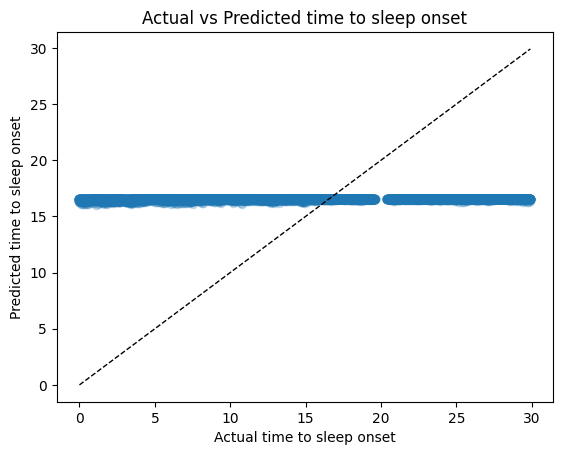

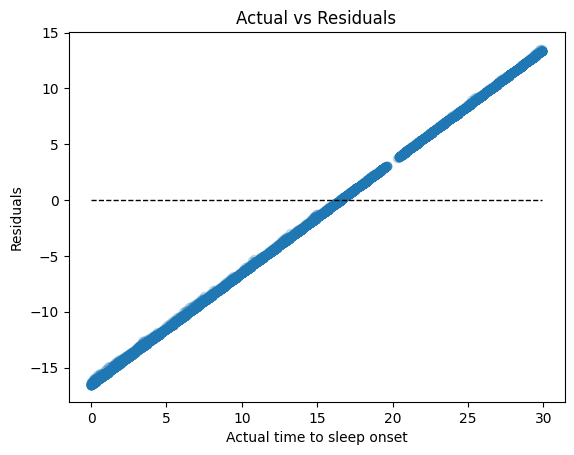

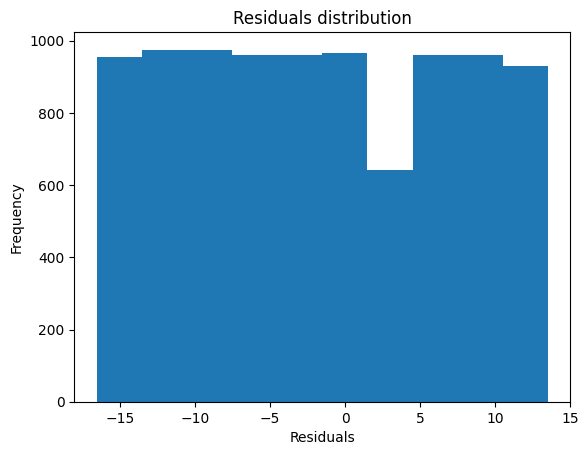

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


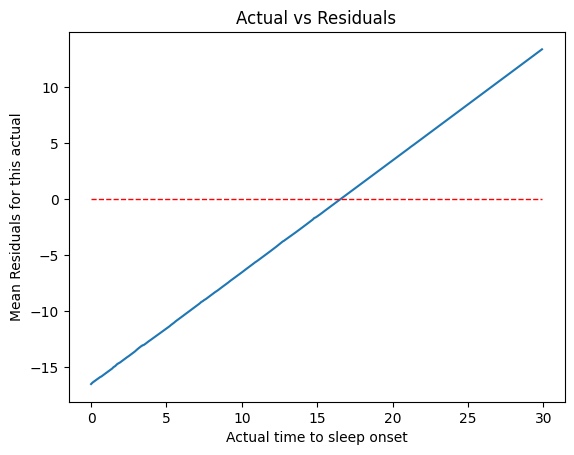

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


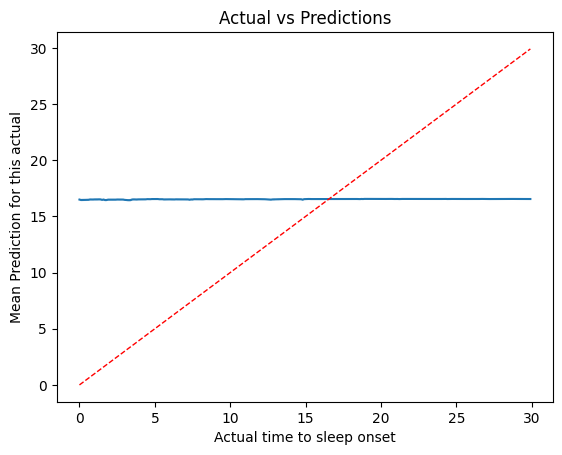

([12.60952377319336,
  6.524226188659668,
  7.559499740600586,
  8.768325805664062,
  8.712409973144531],
 [78.06267614997533,
  81.38922477180792,
  80.58561217347363,
  79.79198152460528,
  79.83122997967344],
 StatefulRNN(
   (lstm): LSTM(86, 32, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 array([16.549099, 16.549591, 16.545408, ..., 16.551338, 16.554874,
        16.546192], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 19.2, 19.3, 19.5], dtype=float32),
 79.44474)

In [35]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 5, hidden_size = 32, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.5, batch_size = 1, device = device, 
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss())

In [39]:
data_clean_filled

,Label,Sbj_ID,Age,Gender,Race1,Race2,Race3,Race4,ifCleanOnset,Time2Sleep,...,wrseltr5,slpapnea5,cpap5,dntaldv5,uvula5,insmnia5,rstlesslgs5,whiirs5c,epslpscl5c,hoostmeq5c
0,29.9,12,80,1,1.0,0.0,0.0,0.0,1,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,12.0
1,29.8,12,80,1,1.0,0.0,0.0,0.0,1,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,12.0
2,29.7,12,80,1,1.0,0.0,0.0,0.0,1,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,12.0
3,29.6,12,80,1,1.0,0.0,0.0,0.0,1,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,12.0
4,29.5,12,80,1,1.0,0.0,0.0,0.0,1,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92695,0.4,6790,72,1,1.0,0.0,0.0,0.0,1,57.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,15.0
92696,0.3,6790,72,1,1.0,0.0,0.0,0.0,1,57.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,15.0
92697,0.2,6790,72,1,1.0,0.0,0.0,0.0,1,57.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,15.0
92698,0.1,6790,72,1,1.0,0.0,0.0,0.0,1,57.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,15.0


There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 77.69934844970703, Validation Loss: 92.44736797071639
Mean Squared Error: 87.03820037841797, R2 Score: -0.11089289432209015
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 77.41468048095703, Validation Loss: 92.29928901365825
Mean Squared Error: 86.77699279785156, R2 Score: -0.1075590843771248
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 75.59105682373047, Validation Loss: 92.08796070984431
Mean Squared Error: 86.33074951171875, R2 Score: -0.10186353216854171
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 4/5, Loss: 77.5606

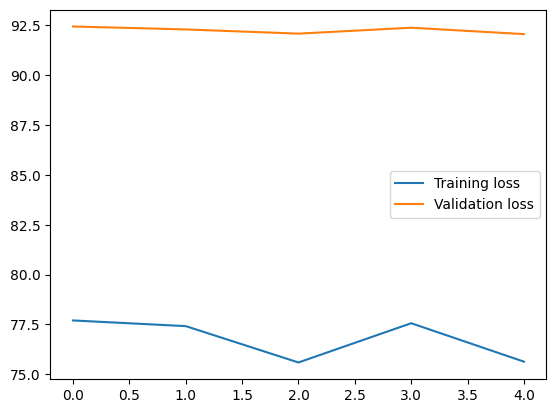

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Test Loss: 90.75957133727414
Mean Squared Error: 86.12128
R2 Score: -0.09884777901062503
Mean Absolute Error: 7.7944756
Test MSE: 86.12128
Test R2: -0.09884777901062503
Test MAE: 7.7944756
Mean Absolute Error: 7.79
Accuracy: -inf %.
Mean Squared Error: 86.12
Root Mean Squared Error: 9.28
R2: -0.1


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


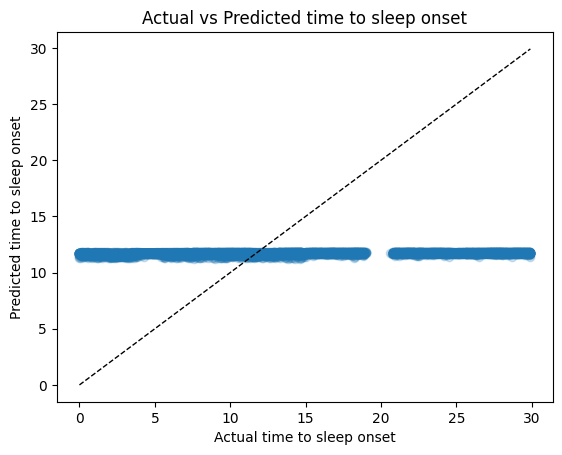

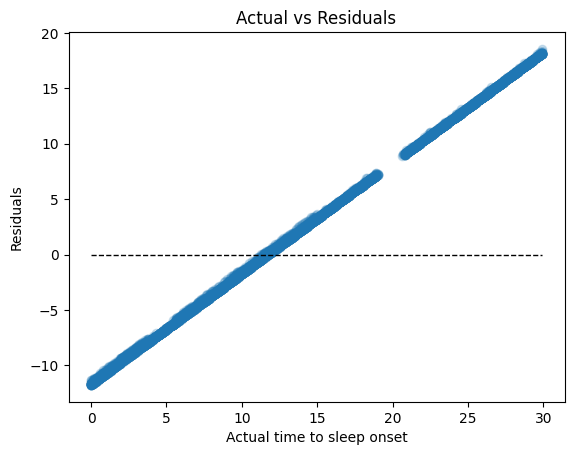

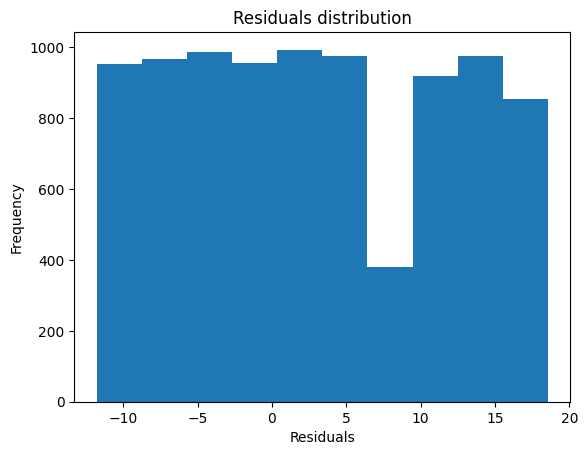

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


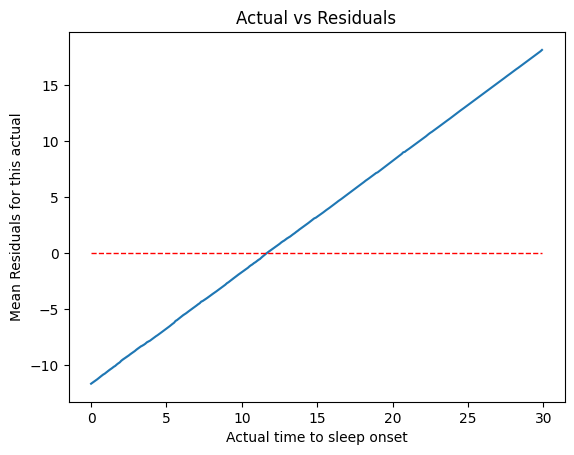

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_29309/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


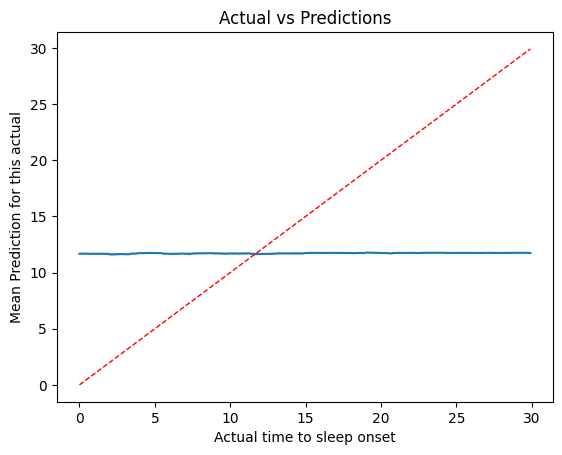

([77.69934844970703,
  77.41468048095703,
  75.59105682373047,
  77.56069946289062,
  75.63240051269531],
 [92.44736797071639,
  92.29928901365825,
  92.08796070984431,
  92.38606522991543,
  92.0647539524805],
 StatefulRNN(
   (lstm): LSTM(86, 32, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 array([11.654934, 11.622405, 11.628991, ..., 11.775303, 11.780255,
        11.758586], dtype=float32),
 array([10.1,  9.6,  9.7, ..., 22.1, 22.2, 18.8], dtype=float32),
 86.12128)

In [41]:
training_loop_RNN_stateful(data_clean_filled, filling_limit = 40, method = 'LOCF', input_size =86, 
                                         num_epochs = 5, hidden_size = 32, num_layers = 2, dropout = 0, 
                                         l2 = 0, lr = 0.001, weight_decay = 0.5, batch_size = 20, device = device, 
                                         random_seed=42, window_size_minutes=2, 
                                         iftest=1, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss())

In [ ]:
columns_to_remove = ['Race1', 'Race2', 'Race3', 'Race4', 'nap5', 'trbleslpng5', 'slpngpills5',
       'sleepy5', 'legsdscmfrt5', 'rubbnglgs5', 'wrserest5', 'wrseltr5',
       'slpapnea5', 'cpap5', 'dntaldv5', 'uvula5', 'insmnia5', 'rstlesslgs5',
       'whiirs5c', 'epslpscl5c', 'hoostmeq5c', 'Gender', 'Age']